<a href="https://colab.research.google.com/github/nithin-sudarsan/Empirical-Code-Review-Investigation/blob/main/code_review_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

In [3]:
filepath = "/content/CodeReview_November292025_07.33.csv"

df = pd.read_csv(filepath)
df = df.iloc[2:, :].reset_index(drop = True)

In [4]:
df.columns

Index(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'Q_RecaptchaScore', 'Q56', 'Q67',
       'Q68', 'Q69', 'Q70', 'Q14_First Click', 'Q14_Last Click',
       'Q14_Page Submit', 'Q14_Click Count', 'Q13', 'Q15', 'Q18',
       'Q20_First Click', 'Q20_Last Click', 'Q20_Page Submit',
       'Q20_Click Count', 'Q21', 'Q22', 'Q23', 'Q24_First Click',
       'Q24_Last Click', 'Q24_Page Submit', 'Q24_Click Count', 'Q25', 'Q26',
       'Q27', 'Q28_First Click', 'Q28_Last Click', 'Q28_Page Submit',
       'Q28_Click Count', 'Q29', 'Q30', 'Q31', 'Q32_First Click',
       'Q32_Last Click', 'Q32_Page Submit', 'Q32_Click Count', 'Q33', 'Q34',
       'Q35', 'Q36_First Click', 'Q36_Last Click', 'Q36_Page Submit',
       'Q36_Click Count

In [5]:
if "Finished" in df.columns:
  df = df[df["Finished"] == "TRUE"].copy()

df["participant_id"] = np.arange(len(df))

In [6]:
len(df)

44

In [7]:
column_map = {
    "experience": "Q68",
    "ai_familiarity": "Q69",
    "ai_use_freq": "Q70",
}

for new, old in column_map.items():
    if old in df.columns:
        df[new] = df[old]
    else:
        print(f"WARNING: Column {old} not found; please update column_map.")


In [8]:
snippet_map = [
    {
        "snippet_id": "sum_list",
        "function_name": "sum_list",
        "bugged": 1,
        "time_q": ["Q14_First Click", "Q14_Last Click", "Q14_Page Submit", "Q14_Click Count"],
        "merge_q": "Q13",
        "conf_qs": ["Q15", "Q18"],
    },
    {
        "snippet_id": "factorial",
        "function_name": "factorial",
        "bugged": 0,
        "time_q": ["Q20_First Click", "Q20_Last Click", "Q20_Page Submit", "Q20_Click Count"],
        "merge_q": "Q21",
        "conf_qs": ["Q22", "Q23"],
    },
    {
        "snippet_id": "title_case",
        "function_name": "title_case",
        "bugged": 1,
        "time_q": ["Q24_First Click", "Q24_Last Click", "Q24_Page Submit", "Q24_Click Count"],
        "merge_q": "Q25",
        "conf_qs": ["Q26", "Q27"],
    },
    {
        "snippet_id": "median_of_three",
        "function_name": "median_of_three",
        "bugged": 0,
        "time_q": ["Q28_First Click", "Q28_Last Click", "Q28_Page Submit", "Q28_Click Count"],
        "merge_q": "Q29",
        "conf_qs": ["Q30", "Q31"],
    },
    {
        "snippet_id": "unique_items",
        "function_name": "unique_items",
        "bugged": 1,
        "time_q": ["Q32_First Click", "Q32_Last Click", "Q32_Page Submit", "Q32_Click Count"],
        "merge_q": "Q33",
        "conf_qs": ["Q34", "Q35"],
    },
    {
        "snippet_id": "is_palindrome",
        "function_name": "is_palindrome",
        "bugged": 0,
        "time_q": ["Q36_First Click", "Q36_Last Click", "Q36_Page Submit", "Q36_Click Count"],
        "merge_q": "Q37",
        "conf_qs": ["Q38", "Q39"],
    },
    {
        "snippet_id": "flatten",
        "function_name": "flatten",
        "bugged": 1,
        "time_q": ["Q40_First Click", "Q40_Last Click", "Q40_Page Submit", "Q40_Click Count"],
        "merge_q": "Q41",
        "conf_qs": ["Q42", "Q43"],
    },
    {
        "snippet_id": "normalize_whitespace",
        "function_name": "normalize_whitespace",
        "bugged": 0,
        "time_q": ["Q44_First Click", "Q44_Last Click", "Q44_Page Submit", "Q44_Click Count"],
        "merge_q": "Q45",
        "conf_qs": ["Q46", "Q47"],
    },
    {
        "snippet_id": "average",
        "function_name": "average",
        "bugged": 1,
        "time_q": ["Q48_First Click", "Q48_Last Click", "Q48_Page Submit", "Q48_Click Count"],
        "merge_q": "Q49",
        "conf_qs": ["Q50", "Q51"],
    },
    {
        "snippet_id": "count_even",
        "function_name": "count_even",
        "bugged": 0,
        "time_q": ["Q52_First Click", "Q52_Last Click", "Q52_Page Submit", "Q52_Click Count"],
        "merge_q": "Q53",
        "conf_qs": ["Q54", "Q55"],
    }
]

In [9]:
long_rows = []

for _, row in df.iterrows():
  pid = row["participant_id"]

  for s in snippet_map:
    snippet_id = s["snippet_id"]
    func = s["function_name"]
    bugged = s["bugged"]
    time_cols = s["time_q"]
    merge_col = s["merge_q"]
    conf_cols = s["conf_qs"]

    first_click_col, Last_click_col, submit_col, click_count_col = time_cols

    first_click = float(row.get(first_click_col, np.nan))
    submit_time = float(row.get(submit_col, np.nan))

    if pd.isna(first_click) or pd.isna(submit_time):
      time_sec = np.nan
    else:
      delta = submit_time - first_click
      time_sec = float(delta)

    merge_val = row.get(merge_col, np.nan)

    conf_val = np.nan
    for c in conf_cols:
      if c in df.columns:
        val = row.get(c, np.nan)
        if not pd.isna(val):
          conf_val = val
          break

    long_rows.append(
      {
          "participant_id": pid,
          "snippet_id": snippet_id,
          "function_name": func,
          "bugged": bugged,
          "time_sec": time_sec,
          "merge_raw": merge_val,
          "confidence_raw": conf_val,
          "experience": row.get("experience", np.nan),
          "ai_familiarity": row.get("ai_familiarity", np.nan),
          "ai_use_freq": row.get("ai_use_freq", np.nan),
          "condition_label": row.get("Condition", np.nan),
      }
    )

long_df = pd.DataFrame(long_rows)

In [10]:
long_df["confidence_raw"] = long_df["confidence_raw"].str.extract('(\d+)', expand=False).astype(float)
long_df["confidence"] = pd.to_numeric(long_df["confidence_raw"], errors="coerce")

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1112703152.py:1: SyntaxWarning: invalid escape sequence '\d'
  long_df["confidence_raw"] = long_df["confidence_raw"].str.extract('(\d+)', expand=False).astype(float)


In [11]:
long_df

,participant_id,snippet_id,function_name,bugged,time_sec,merge_raw,confidence_raw,experience,ai_familiarity,ai_use_freq,condition_label,confidence
0,0,sum_list,sum_list,1,0.653,"No, I wouldn't merge it",5.0,6-12 months,Moderately familiar,Multiple times per day,NaN,5.0
1,0,factorial,factorial,0,1.179,"Yes, I would merge it",4.0,6-12 months,Moderately familiar,Multiple times per day,NaN,4.0
2,0,title_case,title_case,1,1.428,"Yes, I would merge it",3.0,6-12 months,Moderately familiar,Multiple times per day,NaN,3.0
3,0,median_of_three,median_of_three,0,1.677,"Yes, I would merge it",4.0,6-12 months,Moderately familiar,Multiple times per day,NaN,4.0
4,0,unique_items,unique_items,1,1.637,"Yes, I would merge it",3.0,6-12 months,Moderately familiar,Multiple times per day,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
435,43,is_palindrome,is_palindrome,0,0.356,"No, I wouldn't merge it",3.0,More than a year,Very familiar,Multiple times per day,Dev,3.0
436,43,flatten,flatten,1,2.357,"No, I wouldn't merge it",3.0,More than a year,Very familiar,Multiple times per day,Dev,3.0
437,43,normalize_whitespace,normalize_whitespace,0,0.607,"Yes, I would merge it",3.0,More than a year,Very familiar,Multiple times per day,Dev,3.0
438,43,average,average,1,1.055,"Yes, I would merge it",4.0,More than a year,Very familiar,Multiple times per day,Dev,4.0


In [12]:
long_df["label_ai"] = long_df["condition_label"].map(
    {
        "AI-Gen": 1,
        "Dev": 0
    }
)

In [13]:
long_df

,participant_id,snippet_id,function_name,bugged,time_sec,merge_raw,confidence_raw,experience,ai_familiarity,ai_use_freq,condition_label,confidence,label_ai
0,0,sum_list,sum_list,1,0.653,"No, I wouldn't merge it",5.0,6-12 months,Moderately familiar,Multiple times per day,NaN,5.0,NaN
1,0,factorial,factorial,0,1.179,"Yes, I would merge it",4.0,6-12 months,Moderately familiar,Multiple times per day,NaN,4.0,NaN
2,0,title_case,title_case,1,1.428,"Yes, I would merge it",3.0,6-12 months,Moderately familiar,Multiple times per day,NaN,3.0,NaN
3,0,median_of_three,median_of_three,0,1.677,"Yes, I would merge it",4.0,6-12 months,Moderately familiar,Multiple times per day,NaN,4.0,NaN
4,0,unique_items,unique_items,1,1.637,"Yes, I would merge it",3.0,6-12 months,Moderately familiar,Multiple times per day,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,43,is_palindrome,is_palindrome,0,0.356,"No, I wouldn't merge it",3.0,More than a year,Very familiar,Multiple times per day,Dev,3.0,0.0
436,43,flatten,flatten,1,2.357,"No, I wouldn't merge it",3.0,More than a year,Very familiar,Multiple times per day,Dev,3.0,0.0
437,43,normalize_whitespace,normalize_whitespace,0,0.607,"Yes, I would merge it",3.0,More than a year,Very familiar,Multiple times per day,Dev,3.0,0.0
438,43,average,average,1,1.055,"Yes, I would merge it",4.0,More than a year,Very familiar,Multiple times per day,Dev,4.0,0.0


In [14]:
long_df["approve"] = long_df["merge_raw"].map(
    {
        "Yes, I would merge it": 1,
        "No, I wouldn't merge it": 0
    }
)

In [15]:
long_df

,participant_id,snippet_id,function_name,bugged,time_sec,merge_raw,confidence_raw,experience,ai_familiarity,ai_use_freq,condition_label,confidence,label_ai,approve
0,0,sum_list,sum_list,1,0.653,"No, I wouldn't merge it",5.0,6-12 months,Moderately familiar,Multiple times per day,NaN,5.0,NaN,0.0
1,0,factorial,factorial,0,1.179,"Yes, I would merge it",4.0,6-12 months,Moderately familiar,Multiple times per day,NaN,4.0,NaN,1.0
2,0,title_case,title_case,1,1.428,"Yes, I would merge it",3.0,6-12 months,Moderately familiar,Multiple times per day,NaN,3.0,NaN,1.0
3,0,median_of_three,median_of_three,0,1.677,"Yes, I would merge it",4.0,6-12 months,Moderately familiar,Multiple times per day,NaN,4.0,NaN,1.0
4,0,unique_items,unique_items,1,1.637,"Yes, I would merge it",3.0,6-12 months,Moderately familiar,Multiple times per day,NaN,3.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,43,is_palindrome,is_palindrome,0,0.356,"No, I wouldn't merge it",3.0,More than a year,Very familiar,Multiple times per day,Dev,3.0,0.0,0.0
436,43,flatten,flatten,1,2.357,"No, I wouldn't merge it",3.0,More than a year,Very familiar,Multiple times per day,Dev,3.0,0.0,0.0
437,43,normalize_whitespace,normalize_whitespace,0,0.607,"Yes, I would merge it",3.0,More than a year,Very familiar,Multiple times per day,Dev,3.0,0.0,1.0
438,43,average,average,1,1.055,"Yes, I would merge it",4.0,More than a year,Very familiar,Multiple times per day,Dev,4.0,0.0,1.0


In [16]:
long_df["time_sec"] = pd.to_numeric(long_df["time_sec"], errors="coerce")
long_df["time_sec"] = long_df["time_sec"].clip(lower=0.1, upper=30)  # avoid log(0)
long_df["log_time"] = np.log(long_df["time_sec"])

In [17]:
long_df["bugged"] = long_df["bugged"].astype(int)

In [18]:
analysis_df = long_df.dropna(subset=["approve", "label_ai", "confidence", "time_sec"]).copy()

In [19]:
analysis_df

,participant_id,snippet_id,function_name,bugged,time_sec,merge_raw,confidence_raw,experience,ai_familiarity,ai_use_freq,condition_label,confidence,label_ai,approve,log_time
10,1,sum_list,sum_list,1,4.641,"No, I wouldn't merge it",3.0,More than a year,Very familiar,Daily,AI-Gen,3.0,1.0,0.0,1.534930
11,1,factorial,factorial,0,1.028,"No, I wouldn't merge it",4.0,More than a year,Very familiar,Daily,AI-Gen,4.0,1.0,0.0,0.027615
12,1,title_case,title_case,1,8.152,"Yes, I would merge it",5.0,More than a year,Very familiar,Daily,AI-Gen,5.0,1.0,1.0,2.098263
13,1,median_of_three,median_of_three,0,15.634,"Yes, I would merge it",4.0,More than a year,Very familiar,Daily,AI-Gen,4.0,1.0,1.0,2.749448
14,1,unique_items,unique_items,1,10.312,"No, I wouldn't merge it",5.0,More than a year,Very familiar,Daily,AI-Gen,5.0,1.0,0.0,2.333308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,43,is_palindrome,is_palindrome,0,0.356,"No, I wouldn't merge it",3.0,More than a year,Very familiar,Multiple times per day,Dev,3.0,0.0,0.0,-1.032825
436,43,flatten,flatten,1,2.357,"No, I wouldn't merge it",3.0,More than a year,Very familiar,Multiple times per day,Dev,3.0,0.0,0.0,0.857390
437,43,normalize_whitespace,normalize_whitespace,0,0.607,"Yes, I would merge it",3.0,More than a year,Very familiar,Multiple times per day,Dev,3.0,0.0,1.0,-0.499226
438,43,average,average,1,1.055,"Yes, I would merge it",4.0,More than a year,Very familiar,Multiple times per day,Dev,4.0,0.0,1.0,0.053541


## Model 1: Approval (logistic regression with cluster-robust SE)

In [20]:
analysis_df["intercept"] = 1.0

In [21]:
fixed_cols = ["intercept", "label_ai", "bugged"]

In [22]:
X = analysis_df[fixed_cols]
y = analysis_df["approve"]

logit_model = sm.Logit(y, X)
logit_result = logit_model.fit(disp=False)  # to avoid long output spam
print("=== Logistic regression (naive SE) ===")
print(logit_result.summary())

=== Logistic regression (naive SE) ===
                           Logit Regression Results                           
Dep. Variable:                approve   No. Observations:                  388
Model:                          Logit   Df Residuals:                      385
Method:                           MLE   Df Model:                            2
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                 0.03753
Time:                        14:36:33   Log-Likelihood:                -253.08
converged:                       True   LL-Null:                       -262.95
Covariance Type:            nonrobust   LLR p-value:                 5.181e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9370      0.177      5.281      0.000       0.589       1.285
label_ai      -0.3880      0.217     -1.784      0.074      -0.814       0.038
bugged       

In [23]:
logit_robust = logit_model.fit(
    cov_type="cluster",
    cov_kwds={"groups": analysis_df["participant_id"]},
    disp=False
)

print("\n=== Logistic regression with cluster-robust SE (by participant) ===")
print(logit_robust.summary())

odds_ratios = np.exp(logit_robust.params)
print("\nOdds ratios:")
print(odds_ratios)


=== Logistic regression with cluster-robust SE (by participant) ===
                           Logit Regression Results                           
Dep. Variable:                approve   No. Observations:                  388
Model:                          Logit   Df Residuals:                      385
Method:                           MLE   Df Model:                            2
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                 0.03753
Time:                        14:36:33   Log-Likelihood:                -253.08
converged:                       True   LL-Null:                       -262.95
Covariance Type:              cluster   LLR p-value:                 5.181e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9370      0.192      4.875      0.000       0.560       1.314
label_ai      -0.3880      0.246     -1.578      0.115      -0

In [24]:
analysis_df["label_bugged"] = analysis_df["label_ai"] * analysis_df["bugged"]

fixed_cols_inter = ["intercept", "label_ai", "bugged", "label_bugged"]
X2 = analysis_df[fixed_cols_inter]

logit_model2 = sm.Logit(analysis_df["approve"], X2)
logit_robust2 = logit_model2.fit(
    cov_type="cluster",
    cov_kwds={"groups": analysis_df["participant_id"]},
    disp=False
)

print("\n=== Logistic regression with label × bugged interaction ===")
print(logit_robust2.summary())
print("\nOdds ratios (interaction model):")
print(np.exp(logit_robust2.params))


=== Logistic regression with label × bugged interaction ===
                           Logit Regression Results                           
Dep. Variable:                approve   No. Observations:                  388
Model:                          Logit   Df Residuals:                      384
Method:                           MLE   Df Model:                            3
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                 0.03796
Time:                        14:36:33   Log-Likelihood:                -252.97
converged:                       True   LL-Null:                       -262.95
Covariance Type:              cluster   LLR p-value:                 0.0001728
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.8938      0.204      4.390      0.000       0.495       1.293
label_ai        -0.2807      0.322     -0.870      0.384      -0

## Model 2: Confidence (mixed linear model)

In [25]:
# Experience coding
exp_map = {
    "Less than 6 months": 0,
    "6-12 months": 1,
    "More than a year": 2
}

analysis_df["experience_num"] = analysis_df["experience"].map(exp_map)

# AI familiarity coding
fam_map = {
    "Not familiar at all": 0,
    "Slightly familiar": 1,
    "Moderately familiar": 2,
    "Very familiar": 3,
    "Extremely familiar": 4
}

analysis_df["ai_familiarity_num"] = analysis_df["ai_familiarity"].map(fam_map)
analysis_df["experience_num"] = analysis_df["experience"].map(exp_map)
analysis_df["snippet_cat"] = pd.Categorical(analysis_df["snippet_id"])

In [26]:
print(analysis_df["experience"].unique())
print(analysis_df["ai_familiarity"].unique())

['More than a year' '6-12 months' 'Less than 6 months']
['Very familiar' 'Extremely familiar' 'Moderately familiar'
 'Slightly familiar']


In [27]:
formula_conf = """
confidence ~ label_ai
            + bugged
            + experience_num
            + ai_familiarity_num
"""

In [28]:
conf_model = smf.mixedlm(
    formula_conf,
    data=analysis_df,
    groups=analysis_df["participant_id"]
)

conf_result = conf_model.fit(reml=False)
print(conf_result.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  confidence
No. Observations:    388      Method:              ML        
No. Groups:          42       Scale:               0.5731    
Min. group size:     7        Log-Likelihood:      -467.3519 
Max. group size:     10       Converged:           Yes       
Mean group size:     9.2                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           2.527    0.288  8.767 0.000  1.962  3.092
label_ai           -0.070    0.147 -0.479 0.632 -0.359  0.218
bugged             -0.069    0.077 -0.890 0.374 -0.220  0.083
experience_num      0.432    0.121  3.557 0.000  0.194  0.670
ai_familiarity_num  0.225    0.091  2.467 0.014  0.046  0.403
Group Var           0.141    0.062                           



## Model 3: Response Time (mixed linear model on log_time)

In [29]:
time_model = smf.mixedlm(
    "log_time ~ label_ai + bugged",
    data=analysis_df,
    groups=analysis_df["participant_id"],
    re_formula="~1"
)
time_result = time_model.fit()
print(time_result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_time 
No. Observations: 388     Method:             REML     
No. Groups:       42      Scale:              0.9241   
Min. group size:  7       Log-Likelihood:     -574.7767
Max. group size:  10      Converged:          Yes      
Mean group size:  9.2                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.451     0.161  2.805  0.005   0.136   0.766
label_ai   0.094     0.249  0.379  0.705  -0.394   0.583
bugged     0.074     0.098  0.754  0.451  -0.118   0.266
Group Var  0.513     0.150                              



## Descriptive summary

In [30]:

# Approval rates by label
print("\nApproval rate by label:")
print(
    analysis_df.groupby("label_ai")["approve"].mean().rename({0: "Human", 1: "AI"})
)

# Confidence by label
print("\nConfidence by label:")
print(
    analysis_df.groupby("label_ai")["confidence"].describe().rename({0: "Human", 1: "AI"})
)

# Time by label
print("\nTime (sec) by label:")
print(
    analysis_df.groupby("label_ai")["time_sec"].describe().rename({0: "Human", 1: "AI"})
)

# Approval of BUGGED snippets only, by label
print("\nApproval rate for BUGGED snippets only, by label:")
print(
    analysis_df[analysis_df["bugged"] == 1]
    .groupby("label_ai")["approve"]
    .mean()
    .rename({0: "Human", 1: "AI"})
)



Approval rate by label:
label_ai
Human    0.621399
AI       0.531034
Name: approve, dtype: float64

Confidence by label:
          count      mean       std  min  25%  50%  75%  max
label_ai                                                    
Human     243.0  3.864198  0.950247  2.0  3.0  4.0  5.0  5.0
AI        145.0  3.744828  0.888032  2.0  3.0  4.0  4.0  5.0

Time (sec) by label:
          count      mean       std   min    25%    50%    75%     max
label_ai                                                              
Human     243.0  3.386362  4.260180  0.10  0.607  1.342  4.695  25.922
AI        145.0  3.793510  5.526654  0.34  0.795  1.308  4.295  28.945

Approval rate for BUGGED snippets only, by label:
label_ai
Human    0.529412
AI       0.408451
Name: approve, dtype: float64


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

## Approval rate by label

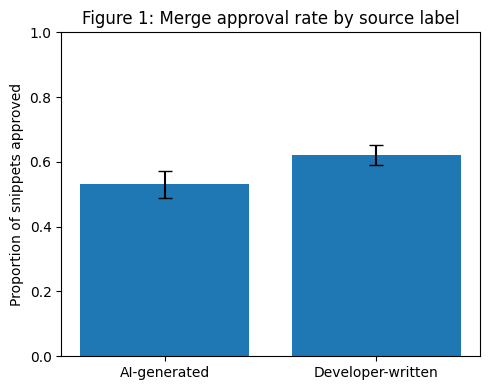

In [35]:
# Map numeric label to readable strings
label_map = {0: "Developer-written", 1: "AI-generated"}
analysis_df["label_name"] = analysis_df["label_ai"].map(label_map)

# Aggregate approval per condition
grouped = analysis_df.groupby("label_name")["approve"]
mean_approval = grouped.mean()
n_per_group = grouped.count()
se_approval = np.sqrt(mean_approval * (1 - mean_approval) / n_per_group)  # standard error of a proportion

# Prepare x positions
labels = mean_approval.index.tolist()
x = np.arange(len(labels))

plt.figure(figsize=(5, 4))
plt.bar(x, mean_approval.values, yerr=se_approval.values, capsize=5)
plt.xticks(x, labels, rotation=0)
plt.ylabel("Proportion of snippets approved")
plt.ylim(0, 1)
plt.title("Figure 1: Merge approval rate by source label")
plt.tight_layout()
plt.savefig("figure1_approval_by_label.png")
plt.show()


Figure 1. Proportion of snippets approved in each label condition. Approval was slightly lower for AI-labelled code, though this difference was not statistically significant. The pattern suggests a mild numerical tendency toward greater caution with AI-labelled code, but no reliable effect of source label on merge decisions.

## Confidence by label

/tmp/ipython-input-1104215159.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_conf, labels=label_order, showfliers=True)


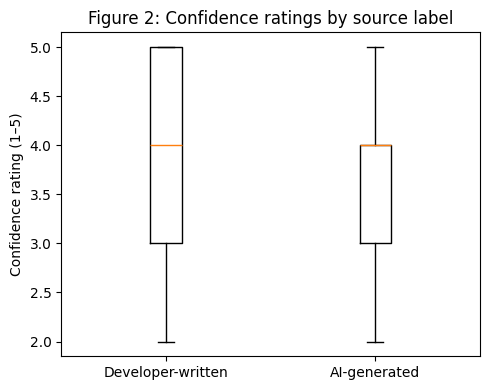

In [36]:
# Ensure label_name exists (from above)
if "label_name" not in analysis_df.columns:
    label_map = {0: "Developer-written", 1: "AI-generated"}
    analysis_df["label_name"] = analysis_df["label_ai"].map(label_map)

# Prepare data for boxplot in consistent label order
label_order = ["Developer-written", "AI-generated"]
data_conf = [analysis_df.loc[analysis_df["label_name"] == lab, "confidence"].dropna()
             for lab in label_order]

plt.figure(figsize=(5, 4))
plt.boxplot(data_conf, labels=label_order, showfliers=True)
plt.ylabel("Confidence rating (1–5)")
plt.title("Figure 2: Confidence ratings by source label")
plt.tight_layout()
plt.savefig("figure2_confidence_by_label.png")
plt.show()


Figure 2. Confidence ratings (1–5) for code-review decisions. Confidence was similar across AI-generated and developer-written snippets, confirming that source label did not significantly affect confidence. Instead, confidence was primarily driven by experience and AI-tool familiarity.

## Response time by label

/tmp/ipython-input-3567708875.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_log_time, labels=label_order, showfliers=True)


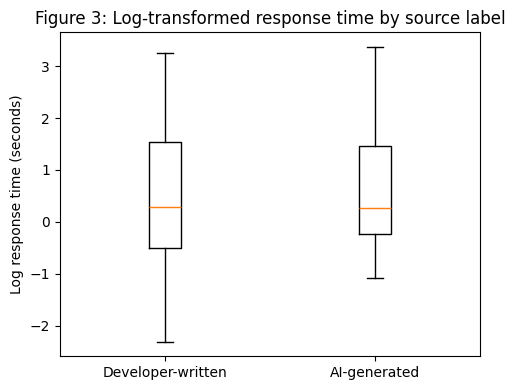

In [37]:
# If not already present, create log_time from time_sec
if "log_time" not in analysis_df.columns:
    analysis_df["time_sec"] = pd.to_numeric(analysis_df["time_sec"], errors="coerce")
    analysis_df["time_sec"] = analysis_df["time_sec"].clip(lower=0.1, upper=30)
    analysis_df["log_time"] = np.log(analysis_df["time_sec"])

label_order = ["Developer-written", "AI-generated"]
data_log_time = [analysis_df.loc[analysis_df["label_name"] == lab, "log_time"].dropna()
                 for lab in label_order]

plt.figure(figsize=(5, 4))
plt.boxplot(data_log_time, labels=label_order, showfliers=True)
plt.ylabel("Log response time (seconds)")
plt.title("Figure 3: Log-transformed response time by source label")
plt.tight_layout()
plt.savefig("figure3_logtime_by_label.png")
plt.show()

Figure 3. Log-transformed decision times for AI-labelled and developer-written snippets. Source attribution did not have a signigicant effect on reponse time, indicating that participants invested similar cognitive effort when reviewing code regardless of the label shown.
